In [33]:
# Import tensorflow 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow import keras

# Import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


# 
import yfinance as yf
from collections import deque


# import 
import numpy as np
import pandas as pd

Preparing the Dataset

In [11]:
# Get data from Yahoo Finance
symbol = "AAPL"
config = {
    "y_finance": {
        "period": "10y", # period to download the data from Yahoo Finance
        "symbol": "AAPL", # TSLA - Tesla
        "key_adjusted_close": "adj close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [12]:
# Get data of a period of recent years
df = yf.download(symbol, period=config['y_finance']['period'])

# Save the data to CSV file
df.to_csv('data/' + symbol + '.csv')

[*********************100%%**********************]  1 of 1 completed


In [13]:
# Loading data from CSV file
df = pd.read_csv('data/' + symbol + '.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-09-09,18.035713,18.139999,17.981428,18.077499,15.777155,340687200
1,2013-09-10,18.078571,18.123215,17.482143,17.665714,15.417765,743195600
2,2013-09-11,16.678928,16.917500,16.600357,16.703930,14.578368,898696400
3,2013-09-12,16.732143,16.978571,16.643213,16.881786,14.733592,404051200
4,2013-09-13,16.762142,16.851070,16.596430,16.603571,14.490783,298835600


In [14]:
# Change column names to lower case to process easier in latter parts
df.columns = df.columns.str.lower()

In [25]:
# Set `date` as dataframe index
df.set_index(pd.DatetimeIndex(df['date']), inplace = True)
df = df.drop('date', axis=1)

In [26]:
df

,open,high,low,close,adj close,volume
date,,,,,,
2013-09-09,18.035713,18.139999,17.981428,18.077499,15.777155,340687200
2013-09-10,18.078571,18.123215,17.482143,17.665714,15.417765,743195600
2013-09-11,16.678928,16.917500,16.600357,16.703930,14.578368,898696400
2013-09-12,16.732143,16.978571,16.643213,16.881786,14.733592,404051200
2013-09-13,16.762142,16.851070,16.596430,16.603571,14.490783,298835600
...,...,...,...,...,...,...
2023-08-31,187.839996,189.119995,187.479996,187.869995,187.869995,60794500
2023-09-01,189.490005,189.919998,188.279999,189.460007,189.460007,45732600
2023-09-05,188.279999,189.979996,187.610001,189.699997,189.699997,45280000


In [27]:
df.describe()

,open,high,low,close,adj close,volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,72.687878,73.493761,71.926947,72.744176,70.832520,1.457858e+08
std,53.787590,54.436943,53.181652,53.836987,54.331088,9.342802e+07
min,15.998571,16.418215,15.972143,16.075714,14.030094,3.145820e+07
25%,28.822500,29.087500,28.502501,28.797501,26.253862,8.463240e+07
50%,45.849998,46.230000,45.285000,45.772499,43.939960,1.170920e+08
75%,127.820000,128.839996,126.120003,127.349998,125.757378,1.785328e+08
max,196.240005,198.229996,195.279999,196.449997,196.185074,1.065523e+09


In [29]:
df_len = df['close'].count()
print(df_len)

2517


In [125]:
# get the adj close values
close_data = df.filter(['adj close'])
dataset = close_data.values

# select a subset of the data for training purpose
# the remaining set of the data is for validation
num_training_points = int(np.ceil(len(dataset) * .95))
print(training)

2392


In [126]:
dataset.shape

(2517, 1)

In [127]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
# # training_set_scaled = sc.fit_transform(training_set)
# print(training_set_scaled.shape)
scaled_data = sc.fit_transform(dataset)

scaled_data_train = scaled_data[0:int(num_training_points), :]

print(scaled_data_train.shape)

(2392, 1)


In [128]:
scaled_data_val = scaled_data[num_training_points:, :]
print(scaled_data_val.shape)

(125, 1)


In [129]:
# Declare a window size
window_size = 60

In [133]:
# Define feature and label data
features = [] # X_train
labels = [] # y_train
for i in range(60, len(scaled_data_train)):
    features.append(scaled_data_train[i-60:i, 0])
    labels.append(scaled_data_train[i, 0])

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Use 1 indicator (adj close price) for prediction only
features = np.reshape(features, (features.shape[0], features.shape[1], 1))

In [134]:
# Modeling
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (features.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)
])

In [135]:
# Check the model summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_12 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_11 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 50)               

In [136]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [137]:
history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1)

Epoch 1/20
73/73 [==============================] - 33s 118ms/step - loss: 0.0122 - mean_absolute_error: 0.0611
Epoch 2/20
73/73 [==============================] - 8s 114ms/step - loss: 0.0024 - mean_absolute_error: 0.0305
Epoch 3/20
73/73 [==============================] - 8s 114ms/step - loss: 0.0026 - mean_absolute_error: 0.0317
Epoch 4/20
73/73 [==============================] - 8s 109ms/step - loss: 0.0024 - mean_absolute_error: 0.0295
Epoch 5/20
73/73 [==============================] - 8s 103ms/step - loss: 0.0020 - mean_absolute_error: 0.0279
Epoch 6/20
73/73 [==============================] - 8s 104ms/step - loss: 0.0019 - mean_absolute_error: 0.0270
Epoch 7/20
73/73 [==============================] - 8s 107ms/step - loss: 0.0019 - mean_absolute_error: 0.0269
Epoch 8/20
73/73 [==============================] - 8s 113ms/step - loss: 0.0019 - mean_absolute_error: 0.0267
Epoch 9/20
73/73 [==============================] - 9s 119ms/step - loss: 0.0020 - mean_absolute_error: 0.0271


In [138]:
scaled_data_test = scaled_data[num_training_points - 60:, :]
x_test = []
y_test = dataset[num_training_points:, :]
for i in range(60, len(scaled_data_test)):
    x_test.append(scaled_data_test[i-60:i, 0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
 
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

4/4 [==============================] - 3s 39ms/step
MSE 52.68834970892779
RMSE 7.25867410130306


In [78]:
import matplotlib.pyplot as plt

C:\Users\thong.lam\AppData\Local\Temp\ipykernel_26980\1271727847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions


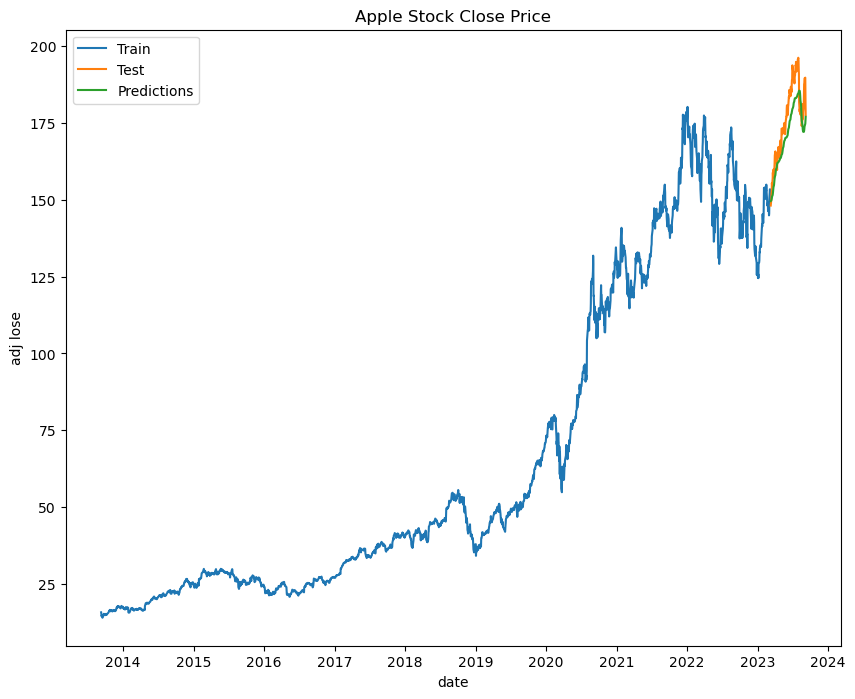

In [139]:
train = df[:num_training_points]
test = df[num_training_points:]
test['predictions'] = predictions
 
plt.figure(figsize=(10, 8))
plt.plot(train.index, train['adj close'])
plt.plot(test.index, test[['adj close', 'predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('date')
plt.ylabel("adj lose")
plt.legend(['Train', 'Test', 'Predictions'])

## Future Predictions

In [143]:
# generate the multi-step forecasts
def multi_step_forecasts(n_past, n_future, data):

    x_past = features[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = labels[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    # add the forecasts to the data frame
    df_past = data.rename(columns={'adj close': 'Actual'}).copy()

    df_future = pd.DataFrame(
        index=pd.bdate_range(start=close_data.index[- n_past - 1] + pd.Timedelta(days=1), periods=n_past + n_future),
        columns=['Forecast'],
        data=y_future
    )

    return df_past.join(df_future, how='outer')

1/1 [==============================] - 0s 40ms/step


<Axes: title={'center': 'AAPL'}>

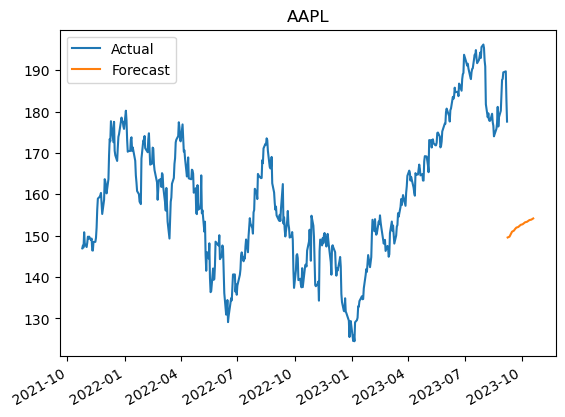

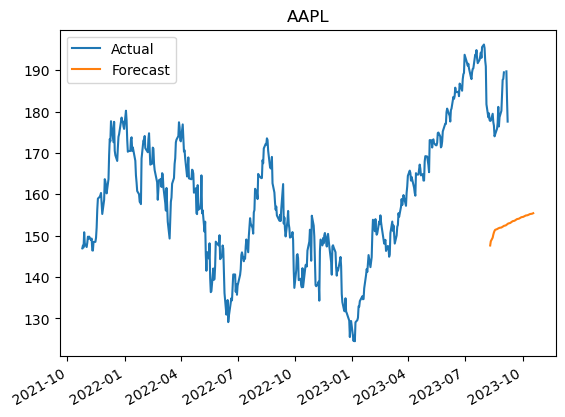

In [146]:
# forecast the next 30 days
df1 = multi_step_forecasts(n_past=0, n_future=30, data=df[['adj close']])
df1.tail(500).plot(title=symbol)

# forecast the last 20 days and the next 30 days
df2 = multi_step_forecasts(n_past=20, n_future=30, data=df[['adj close']])
df2.tail(500).plot(title=symbol)

Hyper Parameters Tuning

In [ ]:
# Handling missing value

In [ ]:
# Handling outliers

In [ ]:
# Scaling

In [103]:
from matplotlib.pyplot import figure

In [105]:
def plot_chart(symbol, data_date, data_feature, num_data_points, display_date_range, config):
    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))

    plt.plot(data_date, data_feature, color=config["plots"]["color_actual"])

    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.title("Daily close price for " + symbol + ", " + display_date_range)
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.show()


In [ ]:
def plot_chart(symbol, data_date, data_feature, num_data_points, display_date_range, config):

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))

    plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
    plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])

    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    
    plt.xticks(x, xticks, rotation='vertical')
    plt.title("Daily close prices for " + config["y_finance"]["symbol"] + " - showing training and validation data")
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

In [95]:
def download_data(symbol):
    # get the data from yahoo finance
    data = yf.download(symbol, period="10y")

    # Change column names to lower case to process easier
    
    data.columns = data.columns.str.lower()

    # Get the date of data points into a list
    data_date = data.index.strftime('%Y-%m-%d').tolist()

    # Get the adjusted price in each data points 
    data_feature = data["adj close"]
    data_feature = np.array(data_feature)
    
    # Get the number of data points
    num_data_points = len(data_date)

    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    return data_date, data_feature, num_data_points, display_date_range

In [96]:
data_date, data_feature, num_data_points, display_date_range = download_data(symbol)

[*********************100%%**********************]  1 of 1 completed
Number data points: 2517 from 2013-09-09 to 2023-09-07


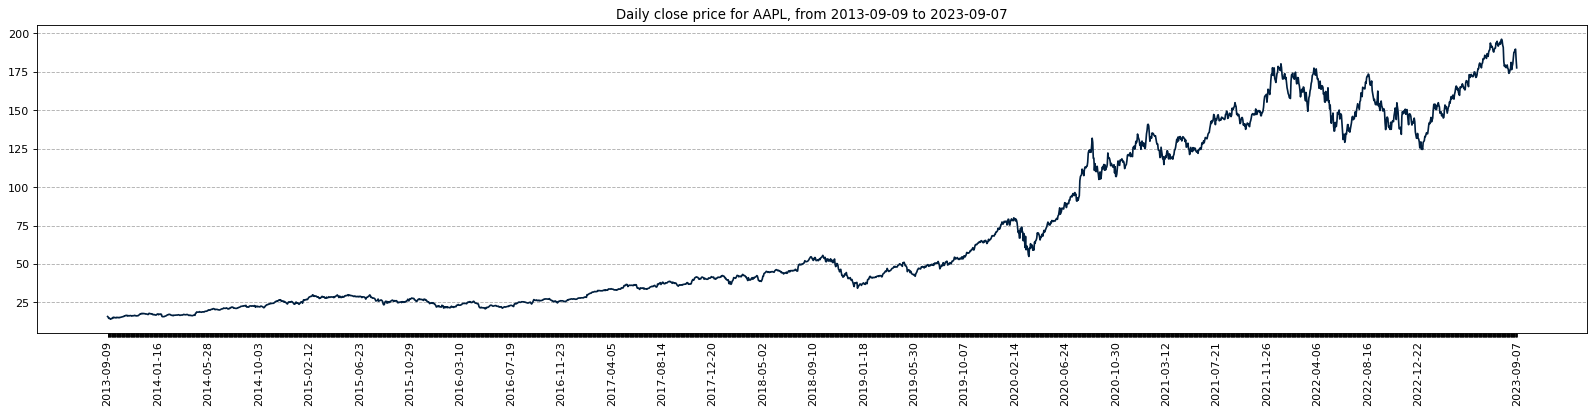

In [106]:
plot_chart(symbol, data_date, data_feature, num_data_points, display_date_range, config)

Tuning the Number of Epochs

Tuning the Batch Size

Tuning the Number of Neurons